   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00


Saving daily_42602_2024.csv to daily_42602_2024.csv
Saving daily_42602_2023.csv to daily_42602_2023.csv
Saving daily_42602_2022.csv to daily_42602_2022.csv
Saving daily_42602_2021.csv to daily_42602_2021.csv
Saving daily_42602_2020.csv to daily_42602_2020.csv
Saving daily_42602_2019.csv to daily_42602_2019.csv
Saving daily_42602_2018.csv to daily_42602_2018.csv
Files found: ['daily_42602_2020.csv', 'daily_42602_2024.csv', 'daily_42602_2022.csv', 'daily_42602_2019.csv', 'daily_42602_2018.csv', 'daily_42602_2021.csv', 'daily_42602_2023.csv']

Linear Regression Results:
MAE = 3.70 | RMSE = 4.82 | R² = 0.512

Random Forest Results:
MAE = 3.80 | RMSE = 4.93 | R² = 0.489

XGBoost Results:
MAE = 3.73 | RMSE = 4.85 | R² = 0.505
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3971
[LightGBM]

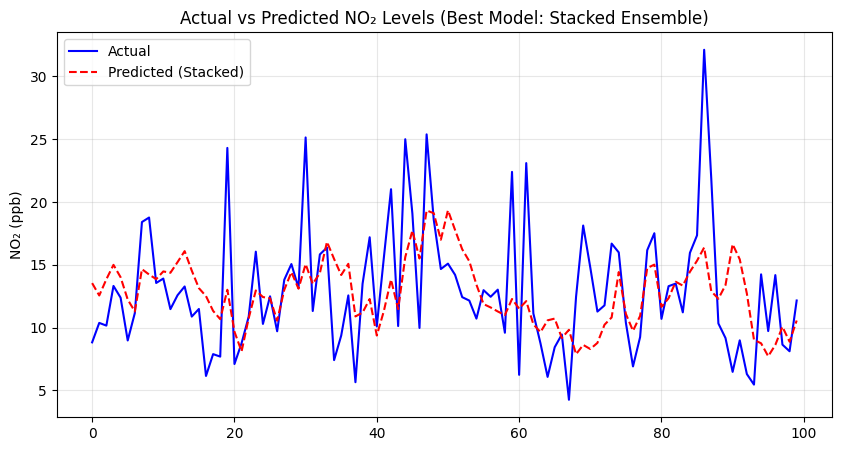

In [2]:

!pip install catboost
from google.colab import files
import pandas as pd
import glob
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')


uploaded = files.upload()
files_list = glob.glob("*.csv")
print("Files found:", files_list)

df = pd.concat((pd.read_csv(f) for f in files_list), ignore_index=True)
df_clean = df[['State Name', 'County Name', 'City Name', 'Date Local',
               'Arithmetic Mean', 'AQI', 'Latitude', 'Longitude']].copy()
df_clean.rename(columns={'Arithmetic Mean': 'NO2 Mean'}, inplace=True)
df_clean['Date Local'] = pd.to_datetime(df_clean['Date Local'])
df_clean.dropna(subset=['NO2 Mean'], inplace=True)

city_df = df_clean[df_clean['City Name'] == 'Houston'].copy()
city_df['Month'] = city_df['Date Local'].dt.month
city_df['DayOfWeek'] = city_df['Date Local'].dt.day_name()
city_df['Year'] = city_df['Date Local'].dt.year
city_df['IsWeekend'] = city_df['DayOfWeek'].isin(['Saturday', 'Sunday']).astype(int)

#fetching enhanced weather data: cloud_cover, hmidity, surface_pressure
lat, lon = city_df['Latitude'].iloc[0], city_df['Longitude'].iloc[0]
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": lat,
    "longitude": lon,
    "start_date": "2018-01-01",
    "end_date": "2024-12-31",
    "daily": [
        "temperature_2m_max", "temperature_2m_min",
        "precipitation_sum", "windspeed_10m_max",
        "cloudcover_mean", "relative_humidity_2m_mean",
        "surface_pressure_mean"
    ],
    "timezone": "America/Chicago"
}
r = requests.get(url, params=params)
weather = pd.DataFrame(r.json()['daily'])
weather['time'] = pd.to_datetime(weather['time'])
weather.rename(columns={
    'temperature_2m_max': 'Temp_Max',
    'temperature_2m_min': 'Temp_Min',
    'precipitation_sum': 'Precipitation',
    'windspeed_10m_max': 'WindSpeed',
    'cloudcover_mean': 'CloudCover',
    'relative_humidity_2m_mean': 'Humidity',
    'surface_pressure_mean': 'Pressure'
}, inplace=True)

merged = pd.merge(city_df, weather, left_on='Date Local', right_on='time', how='inner')
merged.drop(columns='time', inplace=True)

#feature engineering
data = merged.copy().sort_values('Date Local')

#lag and rolling features
for lag in [1, 2, 7, 14, 30]:
    data[f'NO2_Lag{lag}'] = data['NO2 Mean'].shift(lag)

for window in [7, 14, 30]:
    data[f'NO2_Rolling{window}'] = data['NO2 Mean'].rolling(window=window).mean()

#cyclic encodding
data['Month_sin'] = np.sin(2 * np.pi * data['Month'] / 12)
data['Month_cos'] = np.cos(2 * np.pi * data['Month'] / 12)

#interaction features
data['Temp_Wind_Interaction'] = data['Temp_Max'] * data['WindSpeed']
data['Temp_Humidity_Interaction'] = data['Temp_Max'] * data['Humidity']

#drop NA rows
data.dropna(inplace=True)

#modelling
features = [
    'Temp_Max', 'Temp_Min', 'Precipitation', 'WindSpeed', 'CloudCover',
    'Humidity', 'Pressure', 'IsWeekend', 'Month_sin', 'Month_cos',
    'Temp_Wind_Interaction', 'Temp_Humidity_Interaction',
    'NO2_Lag1', 'NO2_Lag2', 'NO2_Lag7', 'NO2_Lag14', 'NO2_Lag30',
    'NO2_Rolling7', 'NO2_Rolling14', 'NO2_Rolling30'
]
target = 'NO2 Mean'

train = data[data['Date Local'].dt.year < 2024]
test = data[data['Date Local'].dt.year == 2024]

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

#feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#model training
def evaluate_model(model, name):
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"\n{name} Results:\nMAE = {mae:.2f} | RMSE = {rmse:.2f} | R² = {r2:.3f}")
    return preds, r2

lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=300, random_state=42)
xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.9, random_state=42)
lgb = LGBMRegressor(n_estimators=300, learning_rate=0.05, num_leaves=31, random_state=42)
cat = CatBoostRegressor(iterations=300, learning_rate=0.05, depth=6, silent=True, random_state=42)

pred_lr, r2_lr = evaluate_model(lr, "Linear Regression")
pred_rf, r2_rf = evaluate_model(rf, "Random Forest")
pred_xgb, r2_xgb = evaluate_model(xgb, "XGBoost")
pred_lgb, r2_lgb = evaluate_model(lgb, "LightGBM")
pred_cat, r2_cat = evaluate_model(cat, "CatBoost")

#ensemble model (stacked)
estimators = [
    ('rf', rf),
    ('xgb', xgb),
    ('lgb', lgb),
    ('cat', cat)
]
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    n_jobs=-1
)
pred_stack, r2_stack = evaluate_model(stack, "Stacked Ensemble")

#results
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost', 'Stacked Ensemble'],
    'R2': [r2_lr, r2_rf, r2_xgb, r2_lgb, r2_cat, r2_stack]
})
print("\n📈 Model Comparison Summary:\n", results.sort_values('R2', ascending=False))

# Plot actual vs best model
best_model_name = results.loc[results['R2'].idxmax(), 'Model']
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:100], label='Actual', color='blue')
if best_model_name == 'Stacked Ensemble':
    plt.plot(pred_stack[:100], label='Predicted (Stacked)', color='red', linestyle='--')
plt.title(f'Actual vs Predicted NO₂ Levels (Best Model: {best_model_name})')
plt.ylabel('NO₂ (ppb)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()